## Cox’s Proportional Hazard model

Lifelines has an implementation of the Cox propotional hazards regression model (implemented in 
R under `coxph`). The idea behind the model is that the log-hazard of an individual is a linear function of their static covariates *and* a population-level baseline hazard that changes over time. Mathematically:

$$\lambda(t | x) = \overbrace{b_0(t)}^{\text{baseline}}\underbrace{\exp \overbrace{\left(\sum_{i=1}^n b_i x_i \right)}^{\text{log-partial hazard}}}_ {\text{partial hazard}}$$

Note a few facts about this model: the only time component is in the baseline hazard, $b_0(t)$. In the above product, the partial hazard is a time-invariant scalar factor that only increases or decreases the baseline hazard. Thus a changes in covariates will only increase or decrease this baseline hazard. 

### Lifelines implementation

The implementation of the Cox model in lifelines, called `CoxPHFitter` has a similar API to `AalensAdditiveFitter`. Like R, it has a `print_summary` function that prints a tabular view of coefficients and related stats. 

This example data is from the paper [here](http://socserv.socsci.mcmaster.ca/jfox/Books/Companion/appendix/Appendix-Cox-Regression.pdf), avaible as `load_rossi` in lifelines. 

To access the coefficients and the baseline hazard directly, you can use `cph.hazards_` and `cph.baseline_hazard_` respectively. 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from lifelines.datasets import load_rossi
from lifelines import CoxPHFitter

rossi_dataset = load_rossi()
cph = CoxPHFitter()
cph.fit(rossi_dataset, duration_col='week', event_col='arrest', show_progress=True)

cph.print_summary()  # access the results using cph.summary

Iteration 1: norm_delta = 0.48337, step_size = 0.95000, ll = -675.38063, seconds_since_start = 0.0
Iteration 2: norm_delta = 0.13160, step_size = 0.95000, ll = -659.79004, seconds_since_start = 0.0
Iteration 3: norm_delta = 0.01712, step_size = 0.95000, ll = -658.76197, seconds_since_start = 0.0
Iteration 4: norm_delta = 0.00103, step_size = 0.95000, ll = -658.74771, seconds_since_start = 0.0
Iteration 5: norm_delta = 0.00005, step_size = 0.95000, ll = -658.74766, seconds_since_start = 0.1
Iteration 6: norm_delta = 0.00000, step_size = 0.95000, ll = -658.74766, seconds_since_start = 0.1
Convergence completed after 6 iterations.
n=432, number of events=114

        coef  exp(coef)  se(coef)       z      p  lower 0.95  upper 0.95    
fin  -0.3794     0.6843    0.1914 -1.9826 0.0474     -0.7545     -0.0043   *
age  -0.0574     0.9442    0.0220 -2.6109 0.0090     -0.1006     -0.0143  **
race  0.3139     1.3688    0.3080  1.0192 0.3081     -0.2898      0.9176    
wexp -0.1498     0.8609    

In [2]:
rossi_dataset.dtypes

week      int64
arrest    int64
fin       int64
age       int64
race      int64
wexp      int64
mar       int64
paro      int64
prio      int64
dtype: object

In [3]:
rossi_dataset.head()

,week,arrest,fin,age,race,wexp,mar,paro,prio
0,20,1,0,27,1,0,0,1,3
1,17,1,0,18,1,0,0,1,8
2,25,1,0,19,0,1,0,1,13
3,52,0,1,23,1,1,1,1,1
4,52,0,0,19,0,1,0,1,3


### Convergence 

Fitting the Cox model to the data involves using gradient descent. Lifelines takes extra effort to help with convergence. If you wish to see the fitting, there is a `show_progress` parameter in `CoxPHFitter.fit` function. For further help, see [Problems with convergence in the Cox Proportional Hazard Model](#).

After fitting, the value of the maximum log-likelihood this available using ``cph._log_likelihood``. Similarly, the score and Hessian matrix are available under ``_score_`` and ``_hessian_`` respectively. The ``_hessian_`` can be used the find the covariance matrix of the coefficients. 

### Goodness of fit and prediction

After fitting, you may want to know how "good" of a fit your model was to the data. Aside from traditional approaches, two methods the author has found useful is to 1. look at the concordance-index (see below section on [Model Selection in Survival Regression](), available as `cph.score_` or in the `print_summary` and 2. compare spread between the baseline survival function vs the Kaplan Meier survival function (Why? a small spread between these two curves means that the impact of the exponential in the Cox model does very little, whereas a large spread means *most* of the changes in individual hazard can be attributed to the exponential term). For example, the first figure below is a good fit, and the second figure is a much weaker fit.

After fitting, you can use use the suite of prediction methods (similar to Aalen's additive model): `.predict_partial_hazard`, `.predict_survival_function`, etc.

In [5]:
X = rossi_dataset.drop(["week", "arrest"], axis=1)
cph.predict_partial_hazard(X)
cph.predict_survival_function(X)

,0,1,2,3,4,5,6,7,8,9,...,422,423,424,425,426,427,428,429,430,431
event_at,,,,,,,,,,,,,,,,,,,,,
0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1.0,0.997616,0.993695,0.994083,0.999045,0.997626,0.997578,0.998865,0.997827,0.995453,0.997462,...,0.997826,0.996005,0.996031,0.997774,0.998892,0.999184,0.997033,0.998866,0.998170,0.998610
2.0,0.995230,0.987411,0.988183,0.998089,0.995250,0.995154,0.997728,0.995653,0.990914,0.994922,...,0.995649,0.992014,0.992067,0.995547,0.997782,0.998366,0.994065,0.997730,0.996337,0.997217
3.0,0.992848,0.981162,0.982314,0.997133,0.992878,0.992734,0.996592,0.993482,0.986392,0.992388,...,0.993476,0.988037,0.988115,0.993324,0.996673,0.997548,0.991105,0.996595,0.994507,0.995826
4.0,0.990468,0.974941,0.976468,0.996176,0.990507,0.990316,0.995455,0.991311,0.981882,0.989855,...,0.991304,0.984067,0.984171,0.991100,0.995563,0.996729,0.988147,0.995458,0.992676,0.994433
5.0,0.988085,0.968739,0.970639,0.995216,0.988135,0.987895,0.994315,0.989139,0.977378,0.987320,...,0.989129,0.980101,0.980231,0.988875,0.994450,0.995909,0.985189,0.994319,0.990843,0.993039
6.0,0.985699,0.962552,0.964820,0.994254,0.985758,0.985471,0.993172,0.986961,0.972877,0.984781,...,0.986950,0.976134,0.976290,0.986645,0.993334,0.995085,0.982227,0.993177,0.989006,0.991640
7.0,0.983305,0.956370,0.959004,0.993287,0.983374,0.983039,0.992024,0.984777,0.968371,0.982235,...,0.984764,0.972162,0.972343,0.984409,0.992213,0.994258,0.979258,0.992030,0.987162,0.990236
8.0,0.971402,0.926001,0.930402,0.988460,0.971520,0.970950,0.986294,0.973910,0.946118,0.969581,...,0.973888,0.952510,0.952816,0.973282,0.986619,0.990125,0.964523,0.986304,0.977978,0.983232


### Plotting the coefficients

With a fitted model, an altervative way to view the coefficients and their ranges is to use the `plot` method.

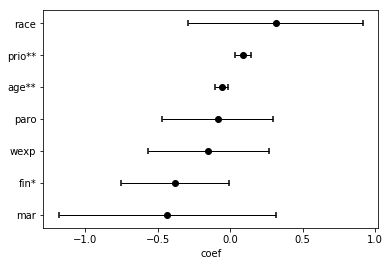

In [6]:
cph.plot()

### Plotting the effect of varying a covariate

After fitting, we can plot what the survival curves look like as we vary a single covarite while 
holding everything else equal. This is useful to understand the impact of a covariate, *given the model*. To do this, we use the `plot_covariate_groups` method and give it the covariate of interest, and the values to display.

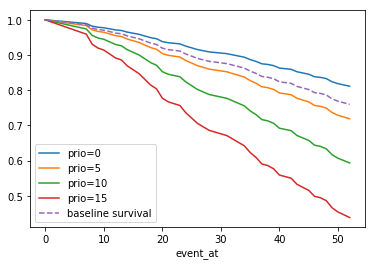

In [7]:
cph.plot_covariate_groups('prio', [0, 5, 10, 15])

### Checking the proportional hazards assumption

A quick and visual way to check the proportional hazards assumption of a variable is to plot the survival curves segmented by the values of the variable. If the survival curves are the same "shape" and differ only by a constant factor, then the assumption holds. A more clear way to see this is to plot what's called the logs curve: the loglogs (-log(survival curve)) vs log(time). If the curves are parallel (and hence do not cross each other), then it's likely the variable satisfies the assumption. If the curves do cross, likely you'll have to "stratify" the variable (see next section). In lifelines, the `KaplanMeierFitter` object has a `.plot_loglogs` function for this purpose. 

The following is the loglogs curves of two variables in our regime dataset. The first is the democracy type, which does have (close to) parallel lines, hence satisfies our assumption:

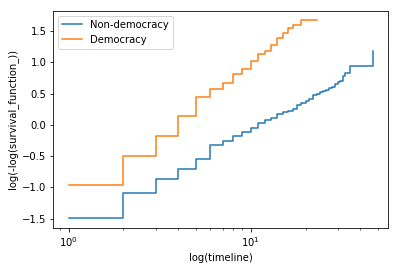

In [8]:
from lifelines.datasets import load_dd
from lifelines import KaplanMeierFitter

data = load_dd()

democracy_0 = data.loc[data['democracy'] == 'Non-democracy']
democracy_1 = data.loc[data['democracy'] == 'Democracy']

kmf0 = KaplanMeierFitter()
kmf0.fit(democracy_0['duration'], event_observed=democracy_0['observed'])

kmf1 = KaplanMeierFitter()
kmf1.fit(democracy_1['duration'], event_observed=democracy_1['observed'])

fig, axes = plt.subplots()
kmf0.plot_loglogs(ax=axes)
kmf1.plot_loglogs(ax=axes)

axes.legend(['Non-democracy', 'Democracy'])

plt.show()

The second variable is the regime type, and this variable does not follow the proportional hazards assumption.

In [9]:
def plot_types(types='regime', data=data):

    data_types = data[types].value_counts().keys()
    
    types = [
        data.loc[data[types] == x] for x in data_types
    ]

    fig, axes = plt.subplots()

    for x in types:
        kmf = KaplanMeierFitter()
        kmf.fit(x['duration'], event_observed=x['observed'])
        kmf.plot_loglogs(ax=axes)

    axes.legend(data_types)

    plt.show()

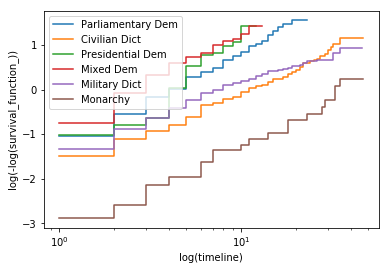

In [10]:
plot_types()

### Stratification

Sometimes a covariate may not obey the proportional hazard assumption. In this case, we can allow a factor without estimating its effect to be adjusted. To specify categorical variables to be used in stratification, we define them in the call to `fit`:

In [11]:
from lifelines.datasets import load_rossi
from lifelines import CoxPHFitter

rossi_dataset = load_rossi()

cph.fit(rossi_dataset, 'week', event_col='arrest', strata=['race'], show_progress=True)

cph.print_summary()  # access the results using cph.summary

Iteration 1: norm_delta = 0.47598, step_size = 0.95000, ll = -636.92697, seconds_since_start = 0.0
Iteration 2: norm_delta = 0.13026, step_size = 0.95000, ll = -621.59413, seconds_since_start = 0.0
Iteration 3: norm_delta = 0.01679, step_size = 0.95000, ll = -620.57773, seconds_since_start = 0.0
Iteration 4: norm_delta = 0.00100, step_size = 0.95000, ll = -620.56366, seconds_since_start = 0.1
Iteration 5: norm_delta = 0.00005, step_size = 0.95000, ll = -620.56361, seconds_since_start = 0.1
Iteration 6: norm_delta = 0.00000, step_size = 0.95000, ll = -620.56361, seconds_since_start = 0.1
Convergence completed after 6 iterations.
n=432, number of events=114

        coef  exp(coef)  se(coef)       z      p  lower 0.95  upper 0.95    
fin  -0.3788     0.6847    0.1913 -1.9799 0.0477     -0.7537     -0.0038   *
age  -0.0576     0.9440    0.0220 -2.6197 0.0088     -0.1008     -0.0145  **
wexp -0.1427     0.8670    0.2128 -0.6708 0.5023     -0.5598      0.2743    
mar  -0.4388     0.6448    

## Model Selection in Survival Regression

If censorship is present, it's not appropriate to use a loss function like mean-squared-error or 
mean-absolute-loss. Instead, one measure is the concordance-index, also known as the c-index. This measure
evaluates the accuracy of the ordering of predicted time. It is infact a generalization
of AUC, another common loss function, and is interpreted similarly: 

* 0.5 is the expected result from random predictions,
* 1.0 is perfect concordance and,
* 0.0 is perfect anti-concordance (multiply predictions with -1 to get 1.0)

The measure is implemented in lifelines under _lifelines.utils.concordance_index_ and accepts the actual times (along with any censorships) and the predicted times.

### Cross Validation

In [12]:
from lifelines import CoxPHFitter
from lifelines.datasets import load_regression_dataset
from lifelines.utils import k_fold_cross_validation

regression_dataset = load_regression_dataset()
cph = CoxPHFitter()
scores = k_fold_cross_validation(cph, regression_dataset, 'T', event_col='E', k=3)
print(scores)
print(np.mean(scores))
print(np.std(scores))

[0.510164569215876, 0.6072449952335558, 0.5887380593262946]
0.5687158745919089
0.04208577107207733
